In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6697137471679987049
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1749391771
locality {
  bus_id: 1
  links {
  }
}
incarnation: 514719073608548765
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
path = './dataset/mnist.npz'

import numpy as np

with np.load(path, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']
    
print(len(x_train))
print(len(y_train))

print(len(x_test))
print(len(y_test))

60000
60000
10000
10000


In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from random import *

In [6]:
x_train = x_train/255.0

In [7]:
print(x_train[0])

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.    

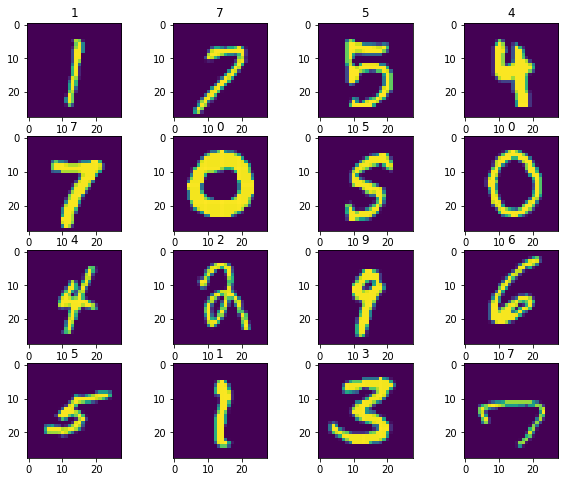

In [8]:


fig = plt.figure(figsize=(10,8))
columns = 4
rows = 4

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    r = randint(0, 59999)
    plt.imshow(x_train[r])
    plt.title(y_train[r])
    
plt.show()

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [10]:
def setup_gpus():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.experimental.set_visible_devices(gpus[0],'GPU')
            tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1500)])
        except RuntimeError as e:
            print(e)
            
setup_gpus()

In [43]:

model = tf.keras.Sequential()

model.add(Conv2D(16,(7,7), name = "conv2d_0", padding='same',input_shape=(28,28,1)))
model.add(Activation('relu'))
# model.add(Activation('relu'))

model.add(Conv2D(32,(5,5), name = "conv2d_1",padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32,(5,5), name = "conv2d_2",padding='same'))
model.add(Activation('relu'))
# model.add(BatchNormalization())

model.add(Dropout(0.2))


model.add(MaxPooling2D(pool_size=(2,2)))



model.add(Conv2D(64,(3,3), name = "conv2d_3",padding='same'))
model.add(Activation('relu'))
# model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), name = "conv2d_4",padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
# model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))



model.add(Flatten(name = "flatten"))
model.add(Dense(512))
model.add(Activation('relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(128))
model.add(Activation('relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))


model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_0 (Conv2D)           (None, 28, 28, 16)        800       
                                                                 
 activation_40 (Activation)  (None, 28, 28, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        12832     
                                                                 
 activation_41 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 activation_42 (Activation)  (None, 28, 28, 32)        0         
                                                                 
 dropout_18 (Dropout)        (None, 28, 28, 32)       

In [44]:
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('../model/without_one_hot.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience = 2,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.5,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]

model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(learning_rate=0.005), metrics = ["accuracy"])

In [45]:
checkpoint = ModelCheckpoint('../model/without_one_hot.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.4,
                              patience=2,
                              verbose=1,
                              min_delta=0.0001)

callbacks = [earlystop,checkpoint,reduce_lr]

model.compile(loss = "sparse_categorical_crossentropy", optimizer = Adam(learning_rate=0.001), metrics = ["accuracy"])

In [46]:
history = model.fit(x_train, y_train, epochs=10, validation_split = 0.30, batch_size = 20, callbacks = callbacks)

Epoch 1/10
2097/2100 [============================>.] - ETA: 0s - loss: 0.1600 - accuracy: 0.9529
Epoch 1: val_accuracy improved from -inf to 0.97778, saving model to ../model\without_one_hot.h5
2100/2100 [==============================] - 15s 7ms/step - loss: 0.1600 - accuracy: 0.9529 - val_loss: 0.0756 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 2/10
2092/2100 [============================>.] - ETA: 0s - loss: 0.0688 - accuracy: 0.9805
Epoch 2: val_accuracy improved from 0.97778 to 0.98094, saving model to ../model\without_one_hot.h5
2100/2100 [==============================] - 14s 6ms/step - loss: 0.0689 - accuracy: 0.9805 - val_loss: 0.0750 - val_accuracy: 0.9809 - lr: 0.0010
Epoch 3/10
2096/2100 [============================>.] - ETA: 0s - loss: 0.0530 - accuracy: 0.9849
Epoch 3: val_accuracy improved from 0.98094 to 0.98861, saving model to ../model\without_one_hot.h5
2100/2100 [==============================] - 14s 7ms/step - loss: 0.0531 - accuracy: 0.9849 - val_loss: 0.0419 - va

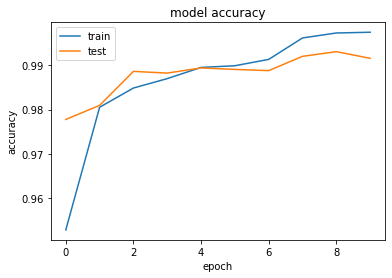

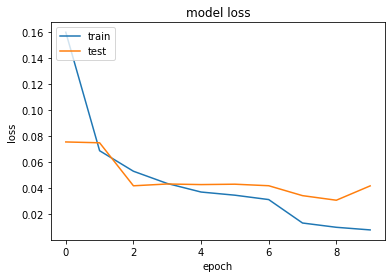

In [47]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
model = tf.keras.models.load_model("../model/without_one_hot.h5")

In [51]:
loss, acc = model.evaluate(x_test, y_test , verbose=2)

313/313 - 1s - loss: 3.9678 - accuracy: 0.9931 - 1s/epoch - 4ms/step


In [53]:
yp = model.predict(x_test)

313/313 [==============================] - 1s 4ms/step


   Actual :  4
Predicted :  [0.000000 0.000000 0.000000 0.000000 1.000000 0.000000 0.000000 0.000000
 0.000000 0.000000]


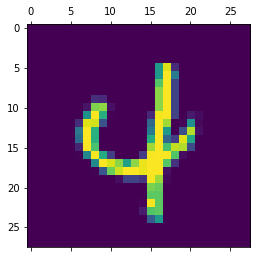

In [54]:
ind = 1300

plt.matshow(x_test[ind])
print("   Actual : ",y_test[ind])
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
print("Predicted : ",yp[ind])
# print(yp[5].shape)

# labels

In [55]:
y_pred_labels = []
for i in yp:
    y_pred_labels.append(np.argmax(i))

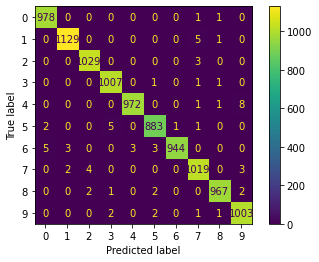

313/313 - 1s - loss: 3.9678 - accuracy: 0.9931 - 1s/epoch - 3ms/step


In [57]:
import pandas as pd
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, y_pred_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


loss, acc = model.evaluate(x_test, y_test , verbose=2)
# print(labels)

In [58]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test, y_pred_labels)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.992893 0.995591 0.994203 0.992118 0.996923 0.991021 0.998942 0.987403
 0.994856 0.987205]
recall: [0.997959 0.994714 0.997093 0.997030 0.989817 0.989910 0.985386 0.991245
 0.992813 0.994054]
fscore: [0.995420 0.995152 0.995646 0.994568 0.993357 0.990466 0.992118 0.989320
 0.993834 0.990617]
support: [ 980 1135 1032 1010  982  892  958 1028  974 1009]
